Modified and verified by **Heejoon Moon**
- version: 11.28

## **0. Preprocessing Data**
- concat RGB frames and opticalflow
- transform videos to '.npy' format
  - '.npy' has 5 channels -> RGB (3) and opticalflow ((u, v) -> 2)
  - you can use another opticalflow algorithms

In [1]:
import numpy as np

def temporal_average(frames, window_size=7):
    """
    ADDED: TEMPORAL AVERAGING
    
    Apply temporal averaging to a list of frames.
    Args:
        frames: List of video frames.
        window_size: Number of frames to include in the averaging window.
    Returns:
        List of temporally averaged frames.
    """
    averaged_frames = []
    for i in range(len(frames)):
        start = max(i - window_size // 2, 0)
        end = min(i + window_size // 2 + 1, len(frames))
        avg_frame = np.mean(frames[start:end], axis=0).astype(np.uint8)
        averaged_frames.append(avg_frame)
    return averaged_frames


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

record_video = False
do_optical_flow_thresholding = True
do_temporal_averaging = True
do_bilateral_filtering = True
optical_flow_threshold = 0.5

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))


    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        # flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
        #                                     cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        
        #CHANGED: Use Farneback method to calculate optical flow
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 
                                    0.5, # pyr_scale
                                    5,   # levels
                                    25,  # winsize
                                    10,   # iterations
                                    7,   # poly_n
                                    1.5, # poly_sigma
                                    cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])

        # ADDED: Calculate magnitude of the flow and apply upper threshold
        if(do_optical_flow_thresholding):
            magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flow[magnitude > optical_flow_threshold] = 0

        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2)))

    return np.array(flows, dtype=np.float32)


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


            # ADDED: Apply bilateral filter to reduce noise 
            if(do_bilateral_filtering): frame = cv2.bilateralFilter(frame, 15, 75, 75)


            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # ADDED: Apply temporal averaging
    if(do_temporal_averaging): frames = temporal_average(frames)

    # Get the optical flow of video
    flows = getOpticalFlow(frames)
    
    # Visualize optical flow map
    #_______________________________________________________________________________________________

    video_name = os.path.splitext(os.path.basename(file_path))[0]
    flow_visual_path = os.path.join("C:/Users/labinno/Desktop/cv_project_2/optical_flow_visuals/", video_name + '_optical_flow.avi')
    # Call farneback_visual with the original frames
    if(record_video): farneback_visual(frames, flows, flow_visual_path)
    
    #_______________________________________________________________________________________________

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result


#CHANGED: Added function to visualize optical flow
def farneback_visual(original_frames, flows, output_path):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (224, 224))
    
    for frame, flow in zip(original_frames, flows):
        # Calculate the magnitude and angle of the flow
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Normalize magnitude from 0 to 255
        mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        # Create HSV image: Hue represents angle, Value represents magniOhs5401031!tude
        hsv = np.zeros_like(frame)
        hsv[..., 0] = ang * (180 / np.pi / 2)  # Angle mapped to hue
        hsv[..., 1] = 255  # Full saturation
        hsv[..., 2] = mag_norm  # Magnitude mapped to value
        color_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        # Overlay the color-coded flow visualization on the original frame
        combined = cv2.addWeighted(frame.astype(np.uint8), 0.7, color_flow, 0.3, 0)
        out.write(combined)

    out.release()


def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

### convert data and save it (offline)

In [3]:
# source_path = 'C:/Users/labinno/Desktop/cv_project_2/raw_video'
# target_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset'

# for f1 in ['train', 'val', 'test']:
#     for f2 in ['Fight', 'NonFight']:
#         path1 = os.path.join(source_path, f1, f2)
#         path2 = os.path.join(target_path, f1, f2)
#         Save2Npy(file_dir=path1, save_dir=path2)

## **1. Build Data Loader**

In [4]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2

class DataGenerator(Dataset):
    
    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, data_augmentation=True, phase='train'):
        self.phase=phase
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data()
        self.print_stats()

    def __len__(self):
        steps_per_epoch = int(len(self.X_path))
        return steps_per_epoch

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        data, label = self.data_generation(self.X_path[index])
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################
    
    def load_data(self, path):
        data = np.load(path, mmap_mode='r', allow_pickle=True) # Read the raw data from path 
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3]) 
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # shuffle data
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)  

    # Normalize data 
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame 
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2) 
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV 
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state sof the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))    
                
    #############################################################
    # Fill the missing part of the code with functions given above
    #############################################################
    
    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories
   
        one_hots = np.eye(len(self.dirs))
 
        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder)  # folder_path = ...train/Fight or ...train/NonFight
            for file in os.listdir(folder_path):
                # Add file path into X_path
                # Assign one hot encoded vector into Y_dict
                file_path = os.path.join(folder_path, file)
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    def data_generation(self, batch_path):
        batch_x = np.array(self.load_data(batch_path))  # Load and convert the data into a numpy array
        batch_y = np.array(self.Y_dict[batch_path])     # Convert the label into a numpy array
        batch_x = torch.from_numpy(batch_x).float()     # Convert batch_x to a PyTorch tensor and ensure float type
        batch_y = torch.from_numpy(batch_y).float()     # Convert batch_y to a PyTorch tensor and ensure long type for labels

        return batch_x, batch_y

## **2. Build Simple Model**
- this model is 'Flow Gated Network' proposed in 'RWF2000'
- you can use off-the-shelf architectures such as ResNet, EfficientNet, etc.
- model structure is produced in below image
- Fully-Connected layer is little bit different with image, so we provide Fully-Connected layer structure

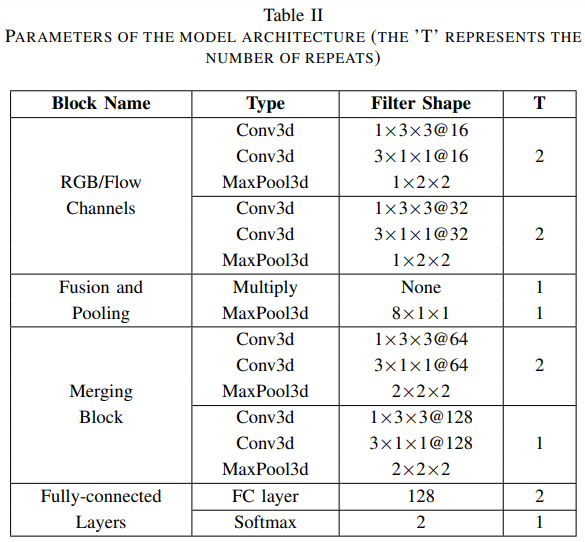

In [5]:
"Global Settings"

BATCH_SIZE = 4
FRAME_NUMBER = 64
EPOCHS = 30

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU(inplace=True)
        
        ## Hint: Please refer to above table for constructing layers
        #______________________________________________________________________________________________________        
        # RGB Channels
        # Construct block of RGB layers which takes RGB channel(3) as input
        self.rgb_conv1 = nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv2 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.rgb_conv3 = nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv4 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.rgb_conv5 = nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv6 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.rgb_conv7 = nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv8 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool4 = nn.MaxPool3d(kernel_size=(1, 2, 2))
     
        # Optical Flow Channels
        # Construct block of optical flow layers which takes the optical flow channel(2) as input
        self.opt_conv1 = nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv2 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.opt_conv3 = nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv4 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.opt_conv5 = nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv6 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.opt_conv7 = nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv8 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool4 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Fusion and Pooling
        self.fusion_maxpool1 = nn.MaxPool3d(kernel_size=(8, 1, 1))
        
        # Merging Block
        self.merge_conv1 = nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.merge_conv2 = nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.merge_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        
        self.merge_conv3 = nn.Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.merge_conv4 = nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.merge_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        
        self.merge_conv5 = nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.merge_conv6 = nn.Conv3d(128, 128, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.merge_maxpool3 = nn.MaxPool3d(kernel_size=(2, 2, 2))

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)        
        self.softmax = nn.Softmax(dim=1)
        
        # Initialize weights
        self.__init_weight()
        
    def forward(self, x):
        rgb = x[...,:3] # Seperate RGB data
        opt = x[...,3:5] # Seperate Optical flow data
        # Reshpae tensor into (#Batch, channel, dimension(#frame), height, width)
        rgb = rgb.contiguous().view(BATCH_SIZE, 3, FRAME_NUMBER, rgb.shape[2], rgb.shape[3]) # 64 is fixed number of frames
        opt = opt.contiguous().view(BATCH_SIZE, 2, FRAME_NUMBER, opt.shape[2], opt.shape[3]) 


        #______________________________________________________________________________________________________
        # Pass through the RGB data through the blocks of RGB layers
        rgb = self.relu(self.rgb_conv1(rgb))
        rgb = self.relu(self.rgb_conv2(rgb))
        rgb = self.rgb_maxpool1(rgb)
        
        rgb = self.relu(self.rgb_conv3(rgb))
        rgb = self.relu(self.rgb_conv4(rgb))
        rgb = self.rgb_maxpool2(rgb)
        
        rgb = self.relu(self.rgb_conv5(rgb))
        rgb = self.relu(self.rgb_conv6(rgb))
        rgb = self.rgb_maxpool3(rgb)
        
        rgb = self.relu(self.rgb_conv7(rgb))
        rgb = self.relu(self.rgb_conv8(rgb))
        rgb = self.rgb_maxpool4(rgb)
        
        # Pass through the optical flow data through the blocks of RGB layers
        opt = self.relu(self.opt_conv1(opt))
        opt = self.relu(self.opt_conv2(opt))
        opt = self.opt_maxpool1(opt)
        
        opt = self.relu(self.opt_conv3(opt))
        opt = self.relu(self.opt_conv4(opt))
        opt = self.opt_maxpool2(opt)
        
        opt = self.relu(self.opt_conv5(opt))
        opt = self.relu(self.opt_conv6(opt))
        opt = self.opt_maxpool3(opt)
        
        opt = self.relu(self.opt_conv7(opt))
        opt = self.relu(self.opt_conv8(opt))
        opt = self.opt_maxpool4(opt)
        
        # Fuse by performing elementwise multiplication of rgb and opt tensors. 
        fused = torch.mul(rgb, opt)
        fused = self.fusion_maxpool1(fused)
        
        #______________________________________________________________________________________________________
        # Pass through the fused data into merging block 
        merged = self.relu(self.merge_conv1(fused))
        merged = self.relu(self.merge_conv2(merged))
        merged = self.merge_maxpool1(merged)
        
        merged = self.relu(self.merge_conv3(merged))
        merged = self.relu(self.merge_conv4(merged))
        merged = self.merge_maxpool2(merged)
        
        merged = self.relu(self.merge_conv5(merged))
        merged = self.relu(self.merge_conv6(merged))
        merged = self.merge_maxpool3(merged)       
        
        #______________________________________________________________________________________________________

        # Fully Connected Layers
        x = merged.view(merged.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        x = self.softmax(x)
        return x
    
    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # Perform weight initialization ("kaiming normal")
                #______________________________________________________________________________________________________
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                #______________________________________________________________________________________________________


## **3. Training the Model**
- set hyper-parameters for training

In [7]:
# !pip install wandb

In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#______________________________________________________________________________________________________
model = FusionModel().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)

loss_fn = nn.BCELoss()
#loss_fn = nn.CrossEntropyLoss()

# Define the paths to your training and validation datasets
# trainset_path = './npy_dataset/train/'
# validation_path = './npy_dataset/val/'
trainset_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset_added_algo/train/'
validation_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset_added_algo/val/'

# Assuming DataGenerator is your dataset class
train_dataset = DataGenerator(trainset_path, phase='train')
for i in range(5):
    data, label = train_dataset[i]
    print(f"Sample {i}: Label - {label}")
val_dataset = DataGenerator(validation_path, phase='val')

# Define DataLoader for both training and validation datasets
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
#______________________________________________________________________________________________________

min_loss = np.inf

Found 160 files belonging to 2 classes.
Fight      : 0
NonFight   : 1
Sample 0: Label - tensor([1., 0.])
Sample 1: Label - tensor([1., 0.])
Sample 2: Label - tensor([1., 0.])
Sample 3: Label - tensor([1., 0.])
Sample 4: Label - tensor([1., 0.])
Found 40 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [9]:
class Train: #added class for trainer__________________________________________________________________________________________
    def __init__(self, model, train_loader, loss_fn, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
    
    def _train(self):
        model.train()
        acc_temp = 0
        running_loss = 0
    #______________________________________________________________________________________________________
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)            
            optimizer.zero_grad()
            output = model(data)
            #output = self.model(data).squeeze()
            
            # print("output:", output)
            # print("Target:", target)

            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (output < 0.5).float()
            acc_temp += (predicted == target).sum().item()

            # print("predicted:", predicted)
            # print("Target:", target)
            # print("acc_temp:", acc_temp)
    #______________________________________________________________________________________________________
        # print("acc_temp_train: ", acc_temp)
        # print("len train_loader_dataset: ", len(train_loader.dataset))

        train_acc = acc_temp / len(train_loader.dataset)
        train_loss = running_loss / len(train_loader.dataset)

        return train_acc, train_loss

In [10]:
class Val: #added class for validation__________________________________________________________________________________________
    def __init__(self, model, val_loader, loss_fn, device):
        self.model = model
        self.val_loader = val_loader
        self.loss_fn = loss_fn
        self.device = device
    
    def _val(self):
        model.eval()
        with torch.no_grad():
            running_loss_val = 0
            acc_temp_val =0

            # calculate accuracy and loss on validation set
    #______________________________________________________________________________________________________
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                #output = self.model(data).squeeze()
                
                loss = loss_fn(output, target)
                running_loss_val += loss.item()

                predicted = (output < 0.5).float()
                acc_temp_val += (predicted == target).sum().item()

    #______________________________________________________________________________________________________
                      
            val_acc = acc_temp_val / len(val_loader.dataset)
            val_loss = running_loss_val / len(val_loader.dataset)

# Convert model output to binary predictions        

        return val_acc, val_loss

In [11]:
import random
import numpy as np

import torch, gc
gc.collect()
torch.cuda.empty_cache()


seed=0
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
    
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

wandb.login()
wandb.init(project='computer vision', name='RWF2000')

trainer = Train(model, train_loader, loss_fn, optimizer, device)
validator = Val(model, val_loader, loss_fn, device)

print(EPOCHS)
for epoch in range(EPOCHS):
    print("Epoch: ", epoch)
    # Perform training and validation
    # Save the weights
    # Log the training and validation results
    #______________________________________________________________________________________________________
    train_accuracy, train_loss = trainer._train()
    val_accuracy, val_loss = validator._val()   
    scheduler.step()

    # Log training and validation results to wandb
    wandb.log({'Epoch': epoch, 'Train Loss': train_loss, 'Train Accuracy': train_accuracy,
               'Val Loss': val_loss, 'Val Accuracy': val_accuracy})
    
    # Save model weights based on validation loss
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), 'model_best.pth')

# Close wandb run
wandb.finish()

#________________________________________________________________________________________________________


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


gpu device is using


wandb: Currently logged in as: hyunseokoh5403. Use `wandb login --relogin` to force relogin


30
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29


Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,▂██▇▁▃▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▂▂▁▁▁▂
Train Loss,█▇▇▅▄▅▄▄▁▃▂▃▃▂▃▃▂▂▃▄▁▂▄▂▂▂▂▂▃▂
Val Accuracy,▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,█▇▇▅▄▃▃▃▂▂▂▃▂▁▂▁▃▁▁▂▁▂▂▁▂▂▁▂▂▂
Epoch,29
Train Accuracy,1.0125
Train Loss,0.17083
Val Accuracy,1.0
Val Loss,0.17083


In [27]:
#best_model = 'model_best.pth'
#test_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset/test'

best_model = "C:/Users/labinno/Desktop/cv_project_2/DL-VideoAnomalyDetect/model_best_original.pth"
test_path = "C:/Users/labinno/Desktop/cv_project_2/npy_dataset_original/test"

test_dataset = DataGenerator(directory=test_path, phase='test')
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)


Found 20 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


Predicted: [0 0 0 0]
Actual: [0 0 0 0]


Predicted: [0 0 0 0]
Actual: [0 0 0 0]


Predicted: [0 0 0 0]
Actual: [0 0 1 1]


Predicted: [0 0 0 0]
Actual: [1 1 1 1]


Predicted: [0 0 0 0]
Actual: [1 1 1 1]


Accuracy: 50.00%
AUROC: 0.5200


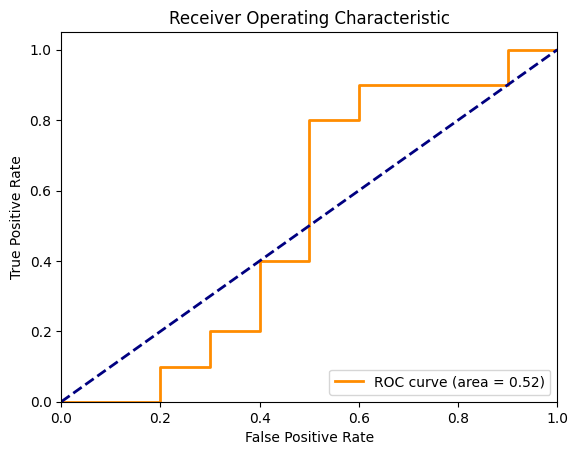

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model))
model.eval()

#______________________________________________________________________________________________________
# Prepare to accumulate predictions and targets
all_preds = []
all_targets = []

# Evaluate the model
correct = 0
total = 0
#______________________________________________________________________________________________________

with torch.no_grad():
    # calculate accuracy and AUROC on test set
    # print accuracy
    # plot AUROC
    
    for data, target in test_loader:
        #print(data.shape, target.shape)

        # Move data to the appropriate device
        data, target = data.to(device), target.to(device)
        #target = target.float()

        # Get model outputs
        outputs = model(data)        

        # Convert outputs to probabilities using softmax
        probabilities = outputs

        # Store predictions (probabilities) and actual targets for AUROC calculation
        all_preds.extend(probabilities[:, 1].cpu().numpy())  # Assuming the positive class is at index 1
           
        target_indices = torch.argmax(target, dim=1).cpu().numpy()
        all_targets.extend(target_indices)

        _, predicted_labels = torch.max(probabilities, 1)
        correct += (predicted_labels == target.argmax(1)).sum().item()

        print("Predicted:", predicted_labels.cpu().numpy())
        print("Actual:", target_indices)
        print("\n")

        total += target.size(0)


all_targets = np.array(all_targets).flatten()
all_preds = np.array(all_preds).flatten()


# Calculate overall accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate AUROC
auroc_score = roc_auc_score(all_targets, all_preds)
print(f'AUROC: {auroc_score:.4f}')

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()